#Financial Time-Series Anomaly Detection

### **Objective**: Build a tool to identify anomalies in stock price trends to detect unusual activities or market manipulations.


The Dataset used is the Yahoo Finance Stock Market Dataset. The "yahoo_finance_dataset(2018-2023)" dataset is a financial dataset containing daily stock market data for multiple assets such as equities, ETFs, and indexes. It spans from April 1, 2018 to March 31, 2023, and contains 1257 rows and 7 columns. The data was sourced from Yahoo Finance, and the purpose of the dataset is to provide researchers, analysts, and investors with a comprehensive dataset that they can use to analyze stock market trends, identify patterns, and develop investment strategies.

In [4]:
pip install mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00


## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

##Step 1: Understanding the Dataset

In [2]:
# Load the Excel file
df = pd.read_excel('/content/yahoo_data.xlsx')

#Converting Date column to date-time format
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True) #sorting values according to the Date

# Display top rows of the file
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000


In [ ]:
df.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close*,float64
Adj Close**,float64
Volume,int64


In [ ]:
# Check for null values
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close*,0
Adj Close**,0
Volume,0


In [ ]:
df.describe()

,Date,Open,High,Low,Close*,Adj Close**,Volume
count,1258,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,2020-10-28 09:39:12.305246464,29595.823045,29776.945739,29402.432226,29599.361677,29599.361677,3.450636e+08
min,2018-05-01 00:00:00,19028.360000,19121.010000,18213.650000,18591.930000,18591.930000,8.615000e+07
25%,2019-07-31 06:00:00,26041.267500,26163.155000,25877.872500,26027.120000,26027.120000,2.773125e+08
50%,2020-10-27 12:00:00,29201.410000,29335.685000,28996.500000,29199.460000,29199.460000,3.247250e+08
75%,2022-01-26 18:00:00,33604.027500,33825.445000,33346.827500,33600.342500,33600.342500,3.875100e+08
max,2023-04-28 00:00:00,36722.600000,36952.650000,36636.000000,36799.650000,36799.650000,9.159900e+08
std,NaN,4006.078299,4009.007573,4004.949066,4007.468822,4007.468822,1.069142e+08


### Data Visualisation with plots

From this plot, we can see how over the years the closing price keeps having an upward or downward trend. Especially in between 2020 and 2021, there was a significant drop in the closing price.

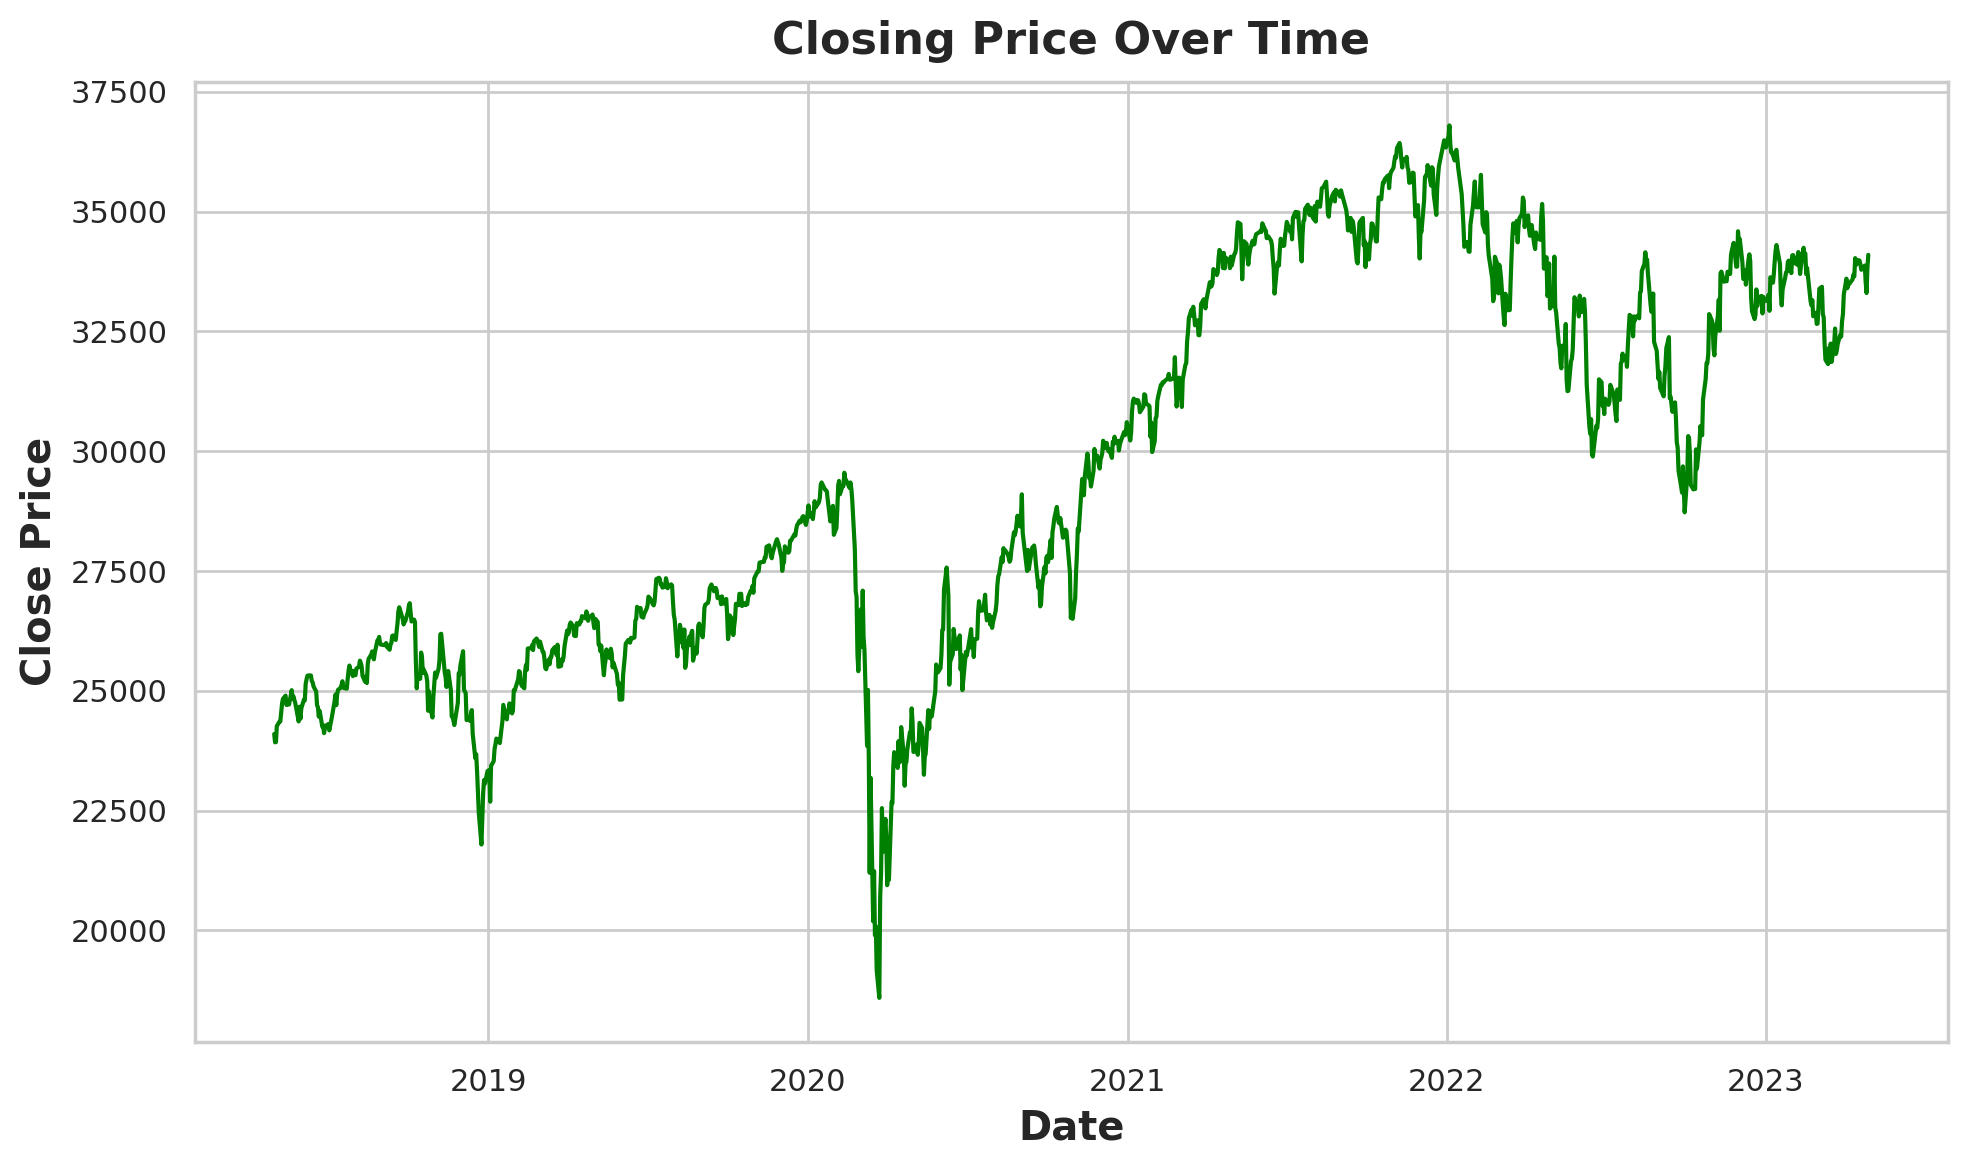

In [ ]:
# Plot closing price over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Date',y='Close*' ,color='green')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

### Visualising stock price movements over time using Candle stick charts

Candle stick charts are helpful in financial analysis as they help to understand trends, identify underlying patterns. This chart compares the stock price with the dates from the last 100 records in the dataset. From this chart, we can see on days if the Closing price is greater than the Opening price, the stock went up and vice versa. The volume bars under the chart show us the trading volume each day.

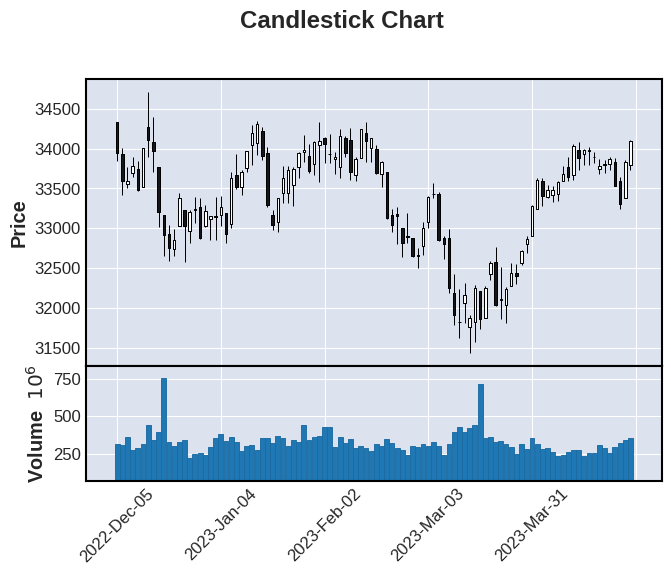

In [5]:
import mplfinance as mpf

# Making Candle stick charts using mplfinance
df_candle = df.set_index('Date')
df_candle = df_candle.rename(columns={'Close*': 'Close'})
df_candle = df_candle[['Open', 'High', 'Low', 'Close', 'Volume']]

mpf.plot(df_candle[-100:], type='candle', volume=True, title='Candlestick Chart')


### This heatmap gives monthly returns which can help to identify seasonal patterns, good or weak months and year-to-year performance. For each month, it calculates the total return (as a percentage change) in the 'Close*' price over that month.

For example, during pandemic years 2020 in March there was a significant negative return which indicates the stock market lost around 15.6 % and then in April, it gained 15.68% which probably indicates that due to a global lockdown, the investors must have sold off their stocks out of fear and it might probably rebounded as some saw this crash as an opportunity to buy stocks in tech or healthcare.  

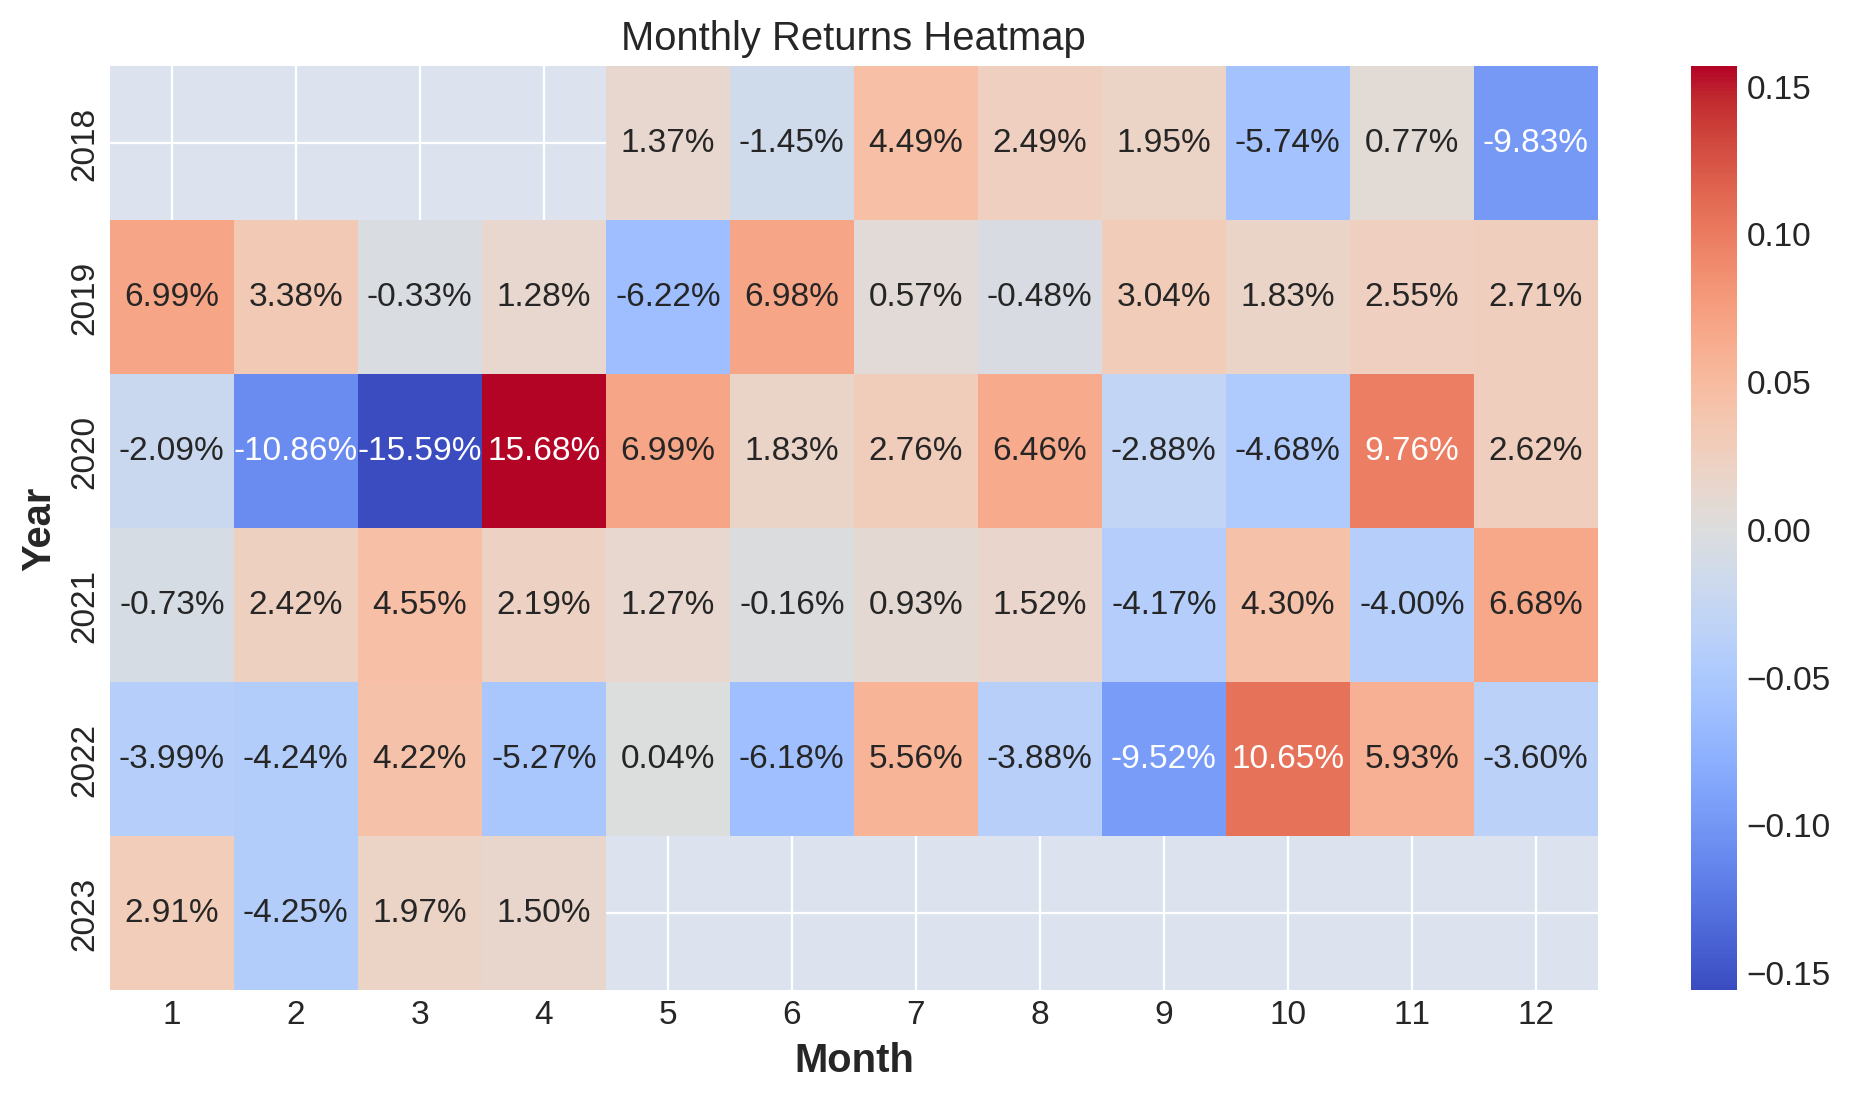

In [ ]:
# Heatmap of Monthly returns which will help to spot good/bad months over years
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Monthly Return'] = df.groupby(df['Date'].dt.to_period("M"))['Close*'].transform(lambda x: x.pct_change().sum())

monthly_returns = df.pivot_table(values='Monthly Return', index='Year', columns='Month', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_returns, cmap='coolwarm', center=0, annot=True, fmt=".2%")
plt.title('Monthly Returns Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


## Data preprocessing

In [6]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Adding Time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()

## Calculating Financial Indicators

First, we calculate the indicators then we can apply scaling to numerical features we want to use for training the model. As SMA/EMA depend on actual price values and RSI uses price changes over time, Bolinger Bands also relies on rolling mean and std dev so these calculations would give incorrect results if we scale them first.

SMA_20 provides us with the average closing price over the last 20 days.


EMA_20 is similar to SMA but is smoother and quicker to adjust compared to SMA.

Bolinger Bands defines volatility boundaries around a moving average so basically it shows whether prices are relatively high or low.

RSI measures momentum so if we see the RSI at index 0 is 60.56 which is a slight strong momentum.




In [ ]:
# SMA (Simple Moving Average) : The average of the closing prices over a fixed number of periods.
"""
SMA is used to smooth price data to help identify trends. If price crosses above SMA then there is possible uptrend otherwise downtrend.

"""
df['SMA_20'] = df['Close*'].rolling(window=20).mean()
print(df['SMA_20'])

# EMA (Exponential Moving Average): A moving average that gives more weight to recent prices
"""
This indicator reacts faster to price changes than SMA
"""
df['EMA_20'] = df['Close*'].ewm(span=20, adjust=False).mean()
print(df['EMA_20'])

# 20-day moving average and std dev
"""
Bolinger Bands: A volatility-based indicator consisting of a moving average (typically SMA 20),
an upper band (+2 standard deviations) and a lower band (−2 standard deviations)
"""
ma = df['SMA_20']
std = df['Close*'].rolling(window=20).std()

df['Bollinger_Upper'] = ma + (2 * std)
print(df['Bollinger_Upper'])
df['Bollinger_Lower'] = ma - (2 * std)
print(df['Bollinger_Lower'])

# RSI( Relative Strength Index): measures the speed and change of price movements.
"""
If RSI > 70 then stock prices are Overbought (price might fall)

If RSI < 30 then stock prices are Oversold (price might rise)

Here the RSI for the Yahoo Finance Stock prices are less than 70
"""
delta = df['Close*'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
print(df['RSI'])



1257           NaN
1256           NaN
1255           NaN
1254           NaN
1253           NaN
           ...    
4       33490.7210
3       33545.6585
2       33591.0395
1       33646.4675
0       33708.4240
Name: SMA_20, Length: 1258, dtype: float64
1257    24099.050000
1256    24082.471905
1255    24067.965057
1254    24086.493147
1253    24112.286180
            ...     
4       33529.486015
3       33529.614013
2       33507.924107
1       33538.232287
0       33591.558736
Name: EMA_20, Length: 1258, dtype: float64
1257             NaN
1256             NaN
1255             NaN
1254             NaN
1253             NaN
            ...     
4       34505.287172
3       34429.419822
2       34302.215612
1       34232.866730
0       34198.440200
Name: Bollinger_Upper, Length: 1258, dtype: float64
1257             NaN
1256             NaN
1255             NaN
1254             NaN
1253             NaN
            ...     
4       32476.154828
3       32661.897178
2       32879.863388
1 

 From this plot, we can interpret that if the closing price reaches the upper Bolinger band, the stock might be overbought as the prices may fall but if it hits the lower band, then stocks can be oversold by investors as stock prices might rise.

The second plot shows us the red line at 70 for overbought threshold and the green line shows the oversold threshold at 30 so using the two plots, we get a complete view of when stocks are trending or exhausted.

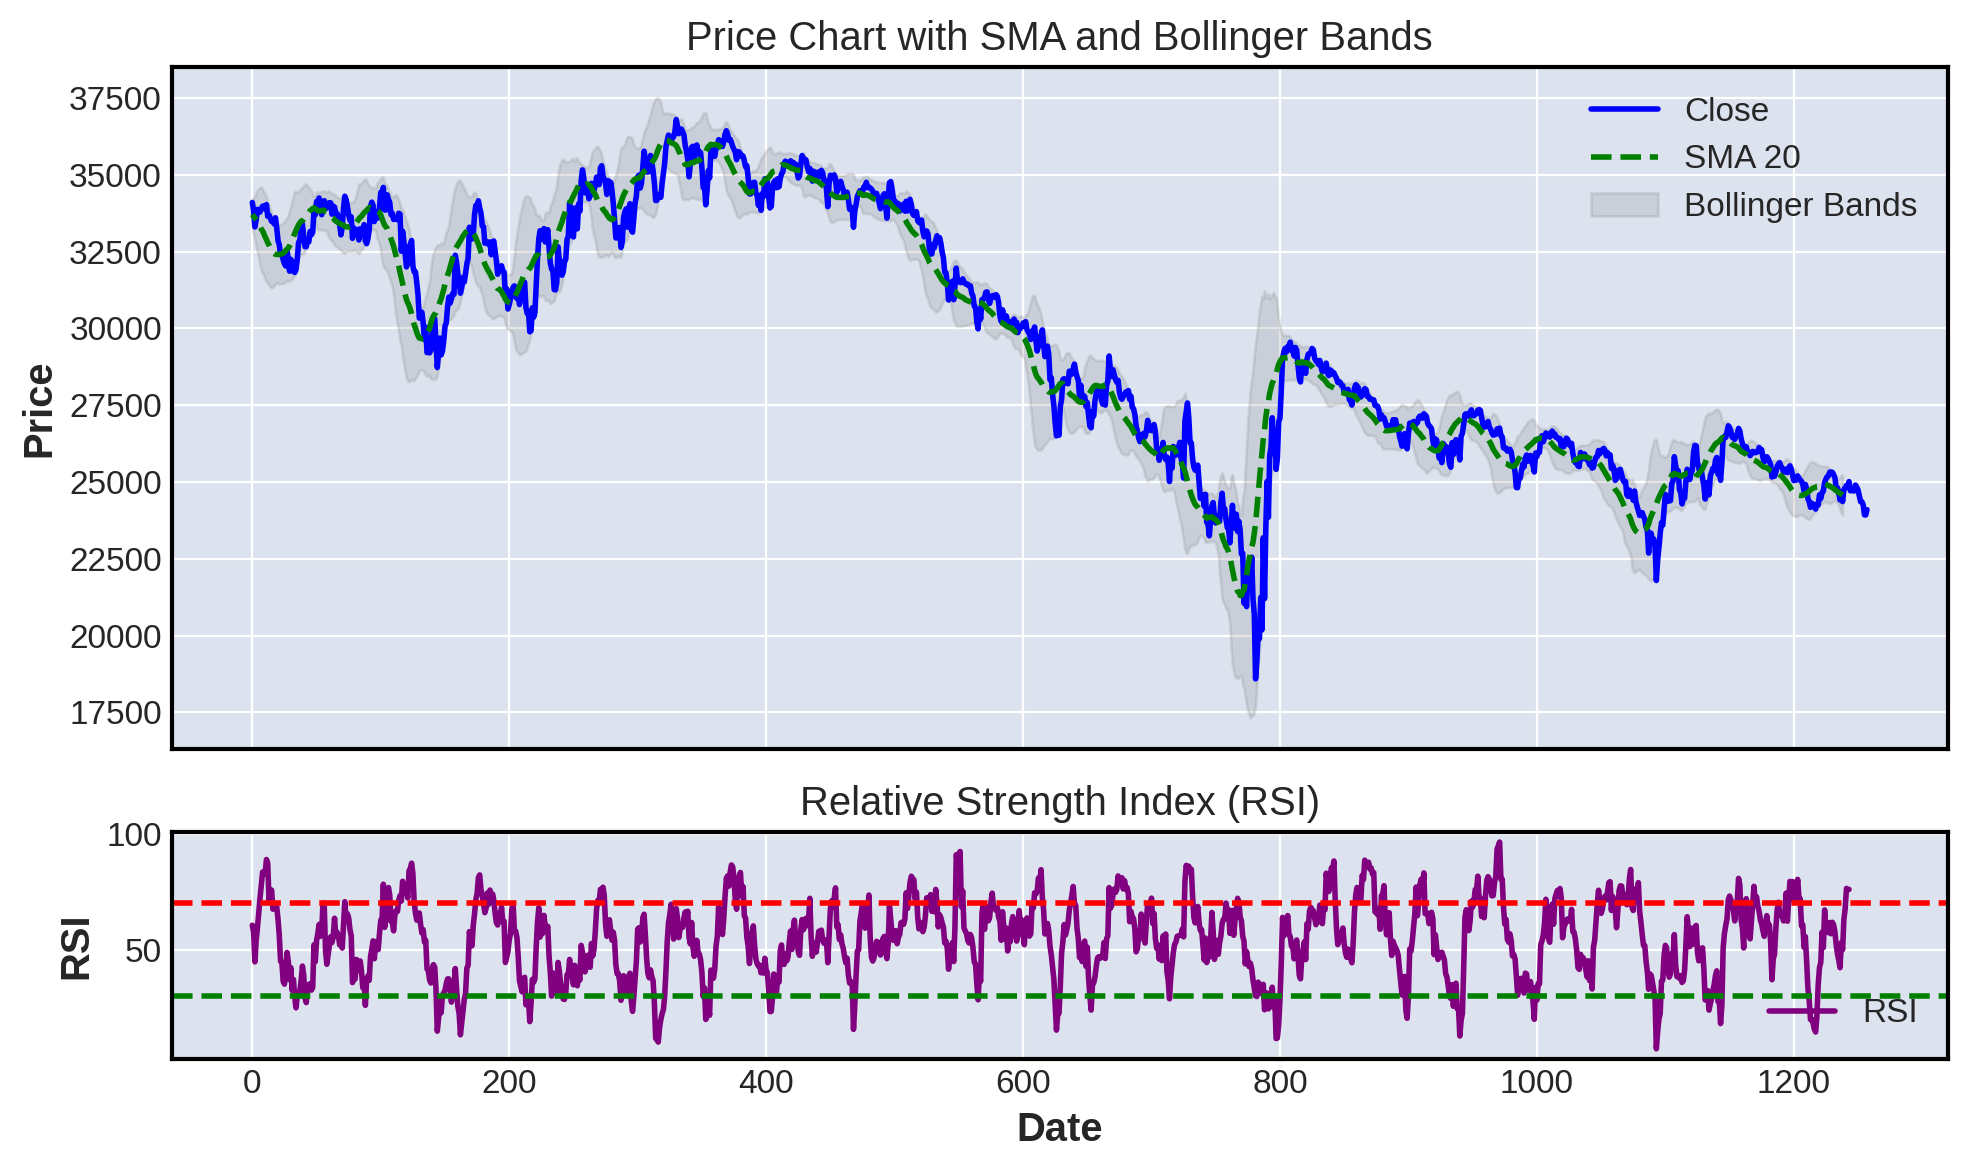

In [ ]:
# Visualisations with Financial Indicators
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Price Chart with SMA and Bollinger Bands
ax1.plot(df.index, df['Close*'], label='Close', color='blue')
ax1.plot(df.index, df['SMA_20'], label='SMA 20', color='green', linestyle='--')
ax1.fill_between(df.index, df['Bollinger_Upper'], df['Bollinger_Lower'], color='grey', alpha=0.2, label='Bollinger Bands')

ax1.set_title('Price Chart with SMA and Bollinger Bands')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# RSI Plot
ax2.plot(df.index, df['RSI'], label='RSI', color='purple')
ax2.axhline(70, color='red', linestyle='--')
ax2.axhline(30, color='green', linestyle='--')

ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

## DBSCAN for unsupervised anomaly detection

DBSCAN is an unsupervised machine learning algorithm used to discover clusters in data based on density. It randomly picks a point and if it's a core point, it forms a new cluster with its neighbors. Then, it expands the cluster recursively to include all density-reachable points and it repeats until all points are visited. It labels non-clustered points as noise (-1).

As we can see from the plot, the two clusters have separated points as well.

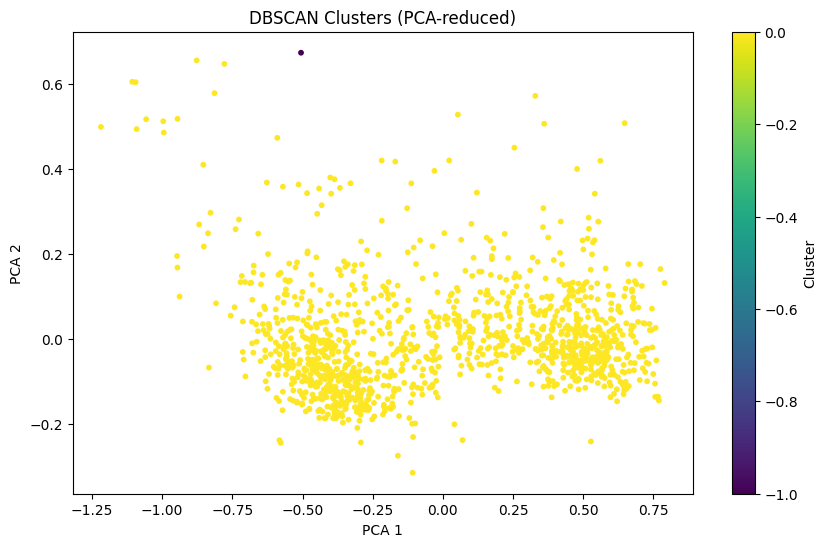

In [ ]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
features_to_scale = ['Open', 'High', 'Low', 'Adj Close**', 'Volume', 'Close*']
scaled_data = scaler.fit_transform(df[features_to_scale])

#Split data into X (features) and y (target)
X = scaled_data[:, :-1] # Input features excluding Close*
y = scaled_data[:, -1] # Target variable: Close*

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.cluster import DBSCAN

# Using scaled features
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)

# Adding a cluster label to the dataframe
df['Cluster'] = dbscan.labels_

from sklearn.decomposition import PCA

#Visualising the clusters using PCA which reduces dimensions from 5 to 2

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', s=10)
plt.title("DBSCAN Clusters (PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.show()

## Time-Series forecasting model using LSTM

The LSTM Model is built with a linear stack of layers with 50 memory units to learn time-dependant patterns and it returns only the last output. It will output a single value which is the predicted closing price. Then, we compile the model to optimise the weights efficiently and using the mean squared error as the loss function which is appropriate for this regression task.

Then, we evaluate the model to see how wrong the model is on unseen data. Since LSTM outputs are often 2D, we have to reshape them to make them comparable to y_test which is a 1D array.

The metrices used to evaluate the model here are the R-squared which tells how well the predictions approximate the actual data which is around 93% accurate.

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

#Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64)

#Evaluate the model
loss = model.evaluate(X_test, y_test)

#Make predictions
predictions = model.predict(X_test)

#Reshape predictions to 1D array
predictions = predictions.reshape(-1, 1) #reshape to match y_test

# Now both y_test and predictions have the same shape
print("Shape of y_test:", y_test.shape)
print("Shape of predictions:", predictions.shape)

# Calculate R-squared
r_squared = r2_score(y_test, predictions)
print("R-squared:", r_squared)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4072
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0937
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Shape of y_test: (252,)
Shape of predictions: (252, 1)
R-squared: 0.9327718214952676


###  MSE value of 0.0030 means that, on average, the squared error is very small, which is good and an RMSE value of 0.055 implies that the model's predictions are off by about 5.5% of the normalised value. From these metrics, we can imply the model is reasonably accurate as it has small errors.



In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.003020573082835227
Root Mean Squared Error (RMSE): 0.05495974056375473


### To visualise the detected anomalies, first we need to calculate the absolute difference between the actual and predicted values for each time step. Next, we set an anomaly threshold which is at 2 std dev above the mean error because most predicted errors would be close to the mean but if an error is larger, we can identify it as a potential anomaly. Then, we detect the anomalies by checking which errors exceed the threshold and where are the indices of time steps where anomalies are present. From this plot, we can see there are 5 anomalies detected between the time steps 200 to 250.

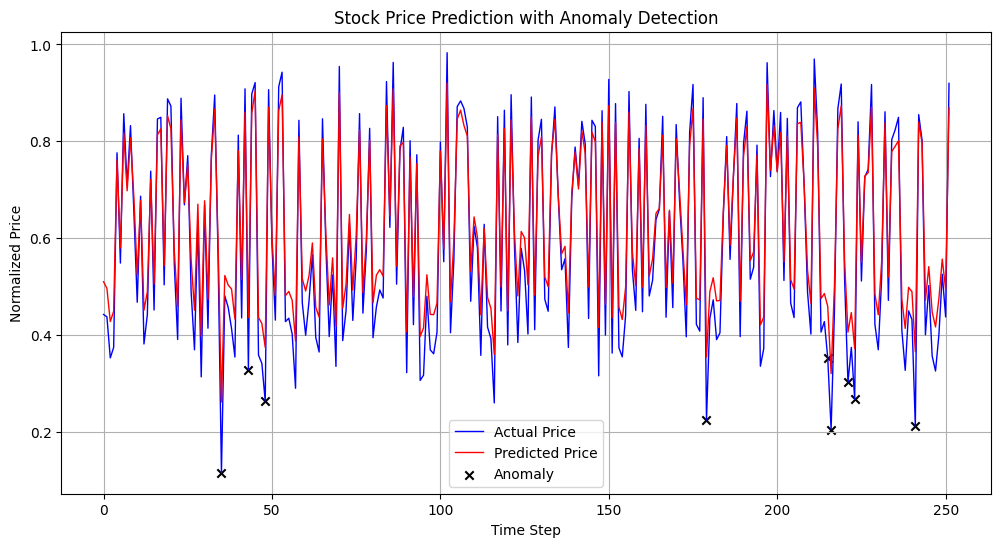

In [ ]:

#calculate absolute difference errors
errors = np.abs(y_test - predictions.reshape(-1))

# Set anomaly threshold (e.g., mean + 2*std deviation)
threshold = np.mean(errors) + 2 * np.std(errors)

# Identify anomalies
anomalies = errors > threshold
anomaly_indices = np.where(anomalies)[0]

# Plot actual vs predicted, highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='blue', linewidth=1)
plt.plot(predictions, label='Predicted Price', color='red', linewidth=1)

# Highlight anomalies on the actual price curve
plt.scatter(anomaly_indices, y_test[anomalies], color='black', label='Anomaly', marker='x')

plt.title('Stock Price Prediction with Anomaly Detection')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()